# Proteogenomics of breast cancer






## 1. Data read  and cleaning 


In [1]:
# Import libraries necessary for this project


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd 
import numpy as np
import os as os



import matplotlib.pyplot as pl
from IPython.display import display 
import visuals2 as vs1

%pylab inline
%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
#data read 


# Load the clinical , expression data and the relevant PAM50 mapping proteins 
try:
    clinical_data = pd.read_csv("clinical_data_breast_cancer.csv")  
    expression_data=pd.read_csv("77_cancer_proteomes_CPTAC_itraq.csv")
    mapping_proteins=pd.read_csv("PAM50_proteins.csv")

    print(" Clinical data has {} samples with {} features each.".format(*clinical_data.shape))
    print(" Expression data has {} samples with {} features each.".format(*expression_data.shape))
    print(" Protein mapping data has {} samples with {} features each.".format(*mapping_proteins.shape))

except:
    print("One or more datasets could not be loaded. Is the dataset missing?")

 Clinical data has 105 samples with 30 features each.
 Expression data has 12553 samples with 86 features each.
 Protein mapping data has 100 samples with 4 features each.


In [3]:
display(clinical_data.head(n=1))

,Complete TCGA ID,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
0,TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,...,Basal-like,0,-13,3,5,Basal,3,2,2,2


In [4]:
display(expression_data.head(n=1))

,RefSeq_accession_number,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
0,NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.49406,2.765081,0.862659,...,-0.963904,-0.487772,-0.10668,-0.065838,0.65585,-0.552212,-0.39856,0.598585,-0.191285,0.566975


In [5]:
display(mapping_proteins.head(n=1))

,GeneSymbol,RefSeqProteinID,Species,Gene Name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity


In [6]:
#cleanup column names  clinical data and mapping proteins -> nice names
clinical_data.columns =clinical_data.columns.str.replace(' |-', '_')
clinical_data.columns = map(str.lower, clinical_data.columns)
mapping_proteins.columns=map(str.lower, mapping_proteins.columns)
mapping_proteins.columns=mapping_proteins.columns.str.replace(' ','_')

In [7]:
display(clinical_data.head(n=1))

,complete_tcga_id,gender,age_at_initial_pathologic_diagnosis,er_status,pr_status,her2_final_status,tumor,tumor__t1_coded,node,node_coded,...,pam50_mrna,sigclust_unsupervised_mrna,sigclust_intrinsic_mrna,mirna_clusters,methylation_clusters,rppa_clusters,cn_clusters,integrated_clusters_(with_pam50),integrated_clusters_(no_exp),integrated_clusters_(unsup_exp)
0,TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,...,Basal-like,0,-13,3,5,Basal,3,2,2,2


In [8]:
# rename id column 
mapping_proteins.rename(columns={'refseqproteinid':'RefSeq_accession_number'}, inplace=True)

## 2. Exploratory data analysis 

I have to prepare the two data sets for the different ML tasks, in a stepwise manner as we aim to use the clustering output as a variable together with the clinical data in the classification task


Steps for data preparation:

>Clinical data
- Understand the different types of categorical variables; drop the redundant ones ( ie if we have for eg. the `tumor size` and `tumor size coded`, which refers to the same variable . 
- Review frequency of the categorical variables ; transform further several variables to ensure a more balanced data distribution 
- Descriptive statistics for the numerical variables 
- Log transform/min max scale variables as applicable 
- Isolate the relevant molecular data to be used in the expression data 
- Drop further variables that are reduntant or will bias the results (such as `RPPA clusters` which refer to a different cancer subtype categorisation when the task is to predict cancer subtype from molecular and clinical data ; in another case
- Output: clinical data frame : one patient per row with clinical info, molecular data frame: one patient per row with molecular info - to be joined with the expression data and the target data frame (cancer type) to be joined later on with the rest.

>Expression data 
- Normalisation: The data expression data is already normalised by the research group so no significant pre processing needs to be done here
- Convert from long format to wide format, such that we have one patient sample per row 
- Remove duplicates and features with high level of missing data (>20%- generally accepted treshold for biological data)
- Impute missing data by the distribution's median value 
- Select only the expression values for the PAM50 proteins that are known to be involved in breast cancer
- Add molecular data frame to the expression data


### 2.1 Descriptive analysis and data transformation on the clinical dataset 

In [9]:
#Description of categorical variables 

      
print("Unique values in Gender: " + ', '.join(clinical_data['gender'].unique()))
print("Unique values in Estrogen response status: " + ', '.join(clinical_data['er_status'].unique()))
print("Unique values in Progesterone response status: " + ', '.join(clinical_data['pr_status'].unique()))
print("Unique values in human epidermal growth factor receptor 2 (HER2), final status: " + ', '.join(clinical_data['her2_final_status'].unique()))
print("Unique values in Tumor " + ', '.join(clinical_data['tumor'].unique()))
print("Unique values in Tumor T1 coded:" + ', '.join(clinical_data['tumor__t1_coded'].unique()))
print("Unique values in Tumor Node: " + ', '.join(clinical_data['node'].unique()))
print("Unique values in Node coded:  " + ', '.join(clinical_data['node_coded'].unique()))
print("Unique values in PAM50 mRNA: " + ', '.join(clinical_data['pam50_mrna'].unique()))
print("Unique values in Metastasis:  " + ', '.join(clinical_data['metastasis'].unique()))
print("Unique values in Metastasis Coded: " + ', '.join(clinical_data['metastasis_coded'].unique()))
print("Unique values in Breast Cancer stage:  " + ', '.join(clinical_data['ajcc_stage'].unique()))
print("Unique values in converted breast cancer stage:  " + ', '.join(clinical_data['converted_stage'].unique()))
print("Unique values in Vital status: " + ', '.join(clinical_data['vital_status'].unique()))
print("Unique values in RPAA clusters: " + ', '.join(clinical_data['rppa_clusters'].unique()))

Unique values in Gender: FEMALE, MALE
Unique values in Estrogen response status: Negative, Indeterminate, Positive
Unique values in Progesterone response status: Negative, Positive
Unique values in human epidermal growth factor receptor 2 (HER2), final status: Negative, Positive, Equivocal
Unique values in Tumor T3, T2, T1, T4
Unique values in Tumor T1 coded:T_Other, T1
Unique values in Tumor Node: N3, N0, N1, N2
Unique values in Node coded:  Positive, Negative
Unique values in PAM50 mRNA: Basal-like, HER2-enriched, Luminal A, Luminal B
Unique values in Metastasis:  M1, M0
Unique values in Metastasis Coded: Positive, Negative
Unique values in Breast Cancer stage:  Stage IV, Stage IIA, Stage IIB, Stage IIIC, Stage IA, Stage IIIA, Stage IIIB, Stage II, Stage I, Stage III, Stage IB
Unique values in converted breast cancer stage:  No_Conversion, Stage IIA, Stage IIB, Stage I, Stage IIIA, Stage IIIC, Stage IIIB
Unique values in Vital status: DECEASED, LIVING
Unique values in RPAA clusters: 

In [10]:
# we keep the metastasis coded feature and the tumor size grouping in the tumor column
clinical_final=clinical_data.drop(["metastasis","tumor__t1_coded"], axis=1) 

#creating a molecular data frame, with all the molecular data to be added to the expression data 
colNames = clinical_final.columns[clinical_final.columns.str.contains(pat = 'clust|tcga')] 


In [11]:

print(colNames)
molecular_df=clinical_final[colNames]
molecular_df=molecular_df.drop(["rppa_clusters"], axis=1) # drop rppa clusters which are the same as the predictor in the clinical data 


molecular_df.reset_index()
display(molecular_df.head(n=5))
colNames=molecular_df.columns

Index(['complete_tcga_id', 'sigclust_unsupervised_mrna',
       'sigclust_intrinsic_mrna', 'mirna_clusters', 'methylation_clusters',
       'rppa_clusters', 'cn_clusters', 'integrated_clusters_(with_pam50)',
       'integrated_clusters_(no_exp)', 'integrated_clusters_(unsup_exp)'],
      dtype='object')


,complete_tcga_id,sigclust_unsupervised_mrna,sigclust_intrinsic_mrna,mirna_clusters,methylation_clusters,cn_clusters,integrated_clusters_(with_pam50),integrated_clusters_(no_exp),integrated_clusters_(unsup_exp)
0,TCGA-A2-A0T2,0,-13,3,5,3,2,2,2
1,TCGA-A2-A0CM,-12,-13,4,4,4,2,1,1
2,TCGA-BH-A18V,-12,-13,5,5,1,2,2,2
3,TCGA-BH-A18Q,-12,-13,5,5,1,2,2,2
4,TCGA-BH-A0E0,0,-13,5,5,1,2,2,2


In [12]:
clustColNames=colNames.values
clustColNames=np.delete(clustColNames,0)

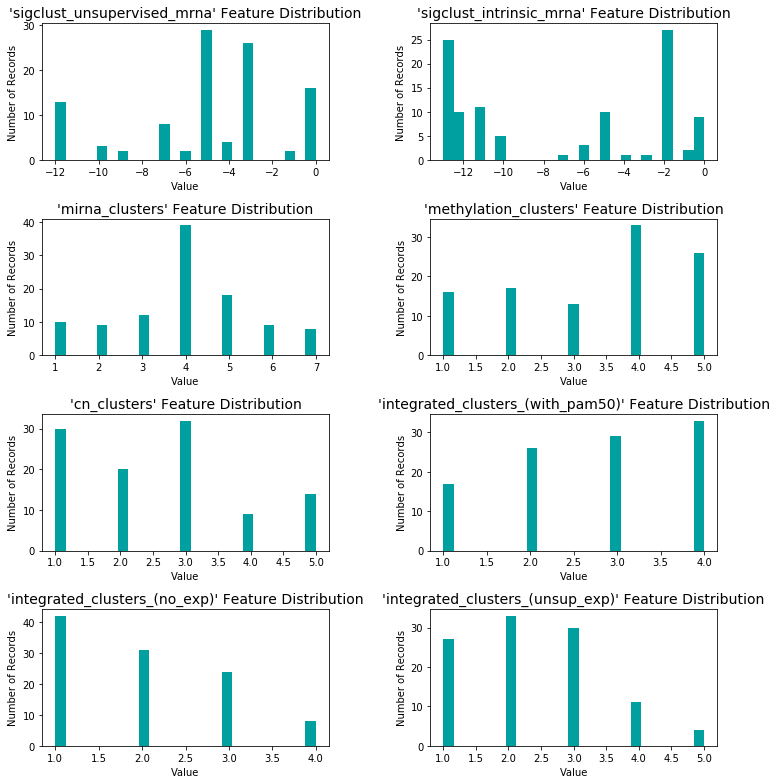

In [13]:

#molecular data frame data , overview of distribution 

fig = pl.figure(figsize = (11,11));

# age and contact info plotting 
for i, feature in enumerate(clustColNames ):
        ax = fig.add_subplot(4, 2, i+1)
        ax.hist(molecular_df[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        
fig.tight_layout()
fig.show()

In [14]:
clinical_final= clinical_final.drop(clustColNames, axis=1)
display(clinical_final.head(n=5))

,complete_tcga_id,gender,age_at_initial_pathologic_diagnosis,er_status,pr_status,her2_final_status,tumor,node,node_coded,metastasis_coded,ajcc_stage,converted_stage,survival_data_form,vital_status,days_to_date_of_last_contact,days_to_date_of_death,os_event,os_time,pam50_mrna,rppa_clusters
0,TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,N3,Positive,Positive,Stage IV,No_Conversion,followup,DECEASED,240,240.0,1,240,Basal-like,Basal
1,TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,N0,Negative,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754.0,1,754,Basal-like,Basal
2,TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,N1,Positive,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1555,1555.0,1,1555,Basal-like,Basal
3,TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,N1,Positive,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1692,1692.0,1,1692,Basal-like,Basal
4,TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,N3,Positive,Negative,Stage IIIC,No_Conversion,followup,LIVING,133,NaN,0,133,Basal-like,Basal


Text(0.5, 1.0, 'Occurences of cancer type based on mRNA PAM50')

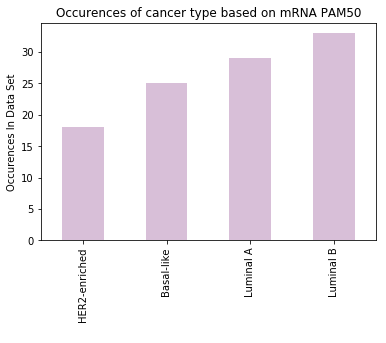

In [15]:
#For the classification task, we will try to predict the cancer subtype, described by the pam50 column 
target_counts= clinical_final['pam50_mrna'].value_counts(ascending=True)

target_counts =  target_counts.plot(kind='bar', color = '#D8BFD8')
target_counts.set_xlabel(" ")
target_counts.set_ylabel("Occurences In Data Set")
target_counts.set_title("Occurences of cancer type based on mRNA PAM50")


In [16]:
clinical_final.describe() # numerical 

,age_at_initial_pathologic_diagnosis,days_to_date_of_last_contact,days_to_date_of_death,os_event,os_time
count,105.000000,105.000000,11.000000,105.000000,105.000000
mean,58.685714,788.390476,1254.454545,0.104762,817.647619
std,13.066630,645.283040,678.050642,0.307715,672.026613
min,30.000000,0.000000,160.000000,0.000000,0.000000
25%,49.000000,240.000000,947.500000,0.000000,240.000000
50%,58.000000,643.000000,1364.000000,0.000000,665.000000
75%,67.000000,1288.000000,1627.500000,0.000000,1305.000000
max,88.000000,2850.000000,2483.000000,1.000000,2850.000000


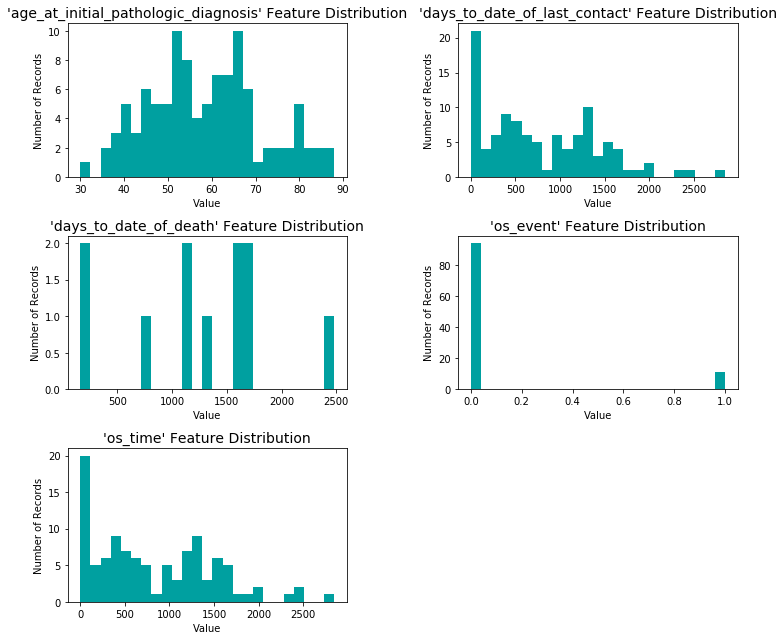

In [18]:
fig = pl.figure(figsize = (11,9));


# age and contact info plotting 
for i, feature in enumerate(['age_at_initial_pathologic_diagnosis','days_to_date_of_last_contact','days_to_date_of_death','os_event','os_time']):
        ax = fig.add_subplot(3, 2, i+1)
        ax.hist(clinical_final[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        
fig.tight_layout()
fig.show()



https://www.cancer.gov/publications/dictionaries/cancer-terms/def/os

Overall survival 
Os event - whether a treatment has been registered 
Os time - time since 


Overall survival (OS)
* OS event - whether a treatment has been registered 
* OS time - The length of time from either the date of diagnosis or the start of treatment for a disease, such as cancer, that patients diagnosed with the disease are still alive.

Most patients do not have an os event registered so we will drop this column, while keeping the overall survival time.

In [19]:
clinical_final=clinical_final.drop(["os_event"], axis=1) 
display(clinical_final.head(n=4))

,complete_tcga_id,gender,age_at_initial_pathologic_diagnosis,er_status,pr_status,her2_final_status,tumor,node,node_coded,metastasis_coded,ajcc_stage,converted_stage,survival_data_form,vital_status,days_to_date_of_last_contact,days_to_date_of_death,os_time,pam50_mrna,rppa_clusters
0,TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,N3,Positive,Positive,Stage IV,No_Conversion,followup,DECEASED,240,240.0,240,Basal-like,Basal
1,TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,N0,Negative,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754.0,754,Basal-like,Basal
2,TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,N1,Positive,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1555,1555.0,1555,Basal-like,Basal
3,TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,N1,Positive,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1692,1692.0,1692,Basal-like,Basal


In [20]:
# Log-transform the skewed features
cancer_type= clinical_final[['complete_tcga_id','pam50_mrna']]

features_raw = clinical_final.drop(['pam50_mrna'], axis = 1) # drop target and unique id 
skewed = ['days_to_date_of_last_contact', 'os_time','days_to_date_of_death']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

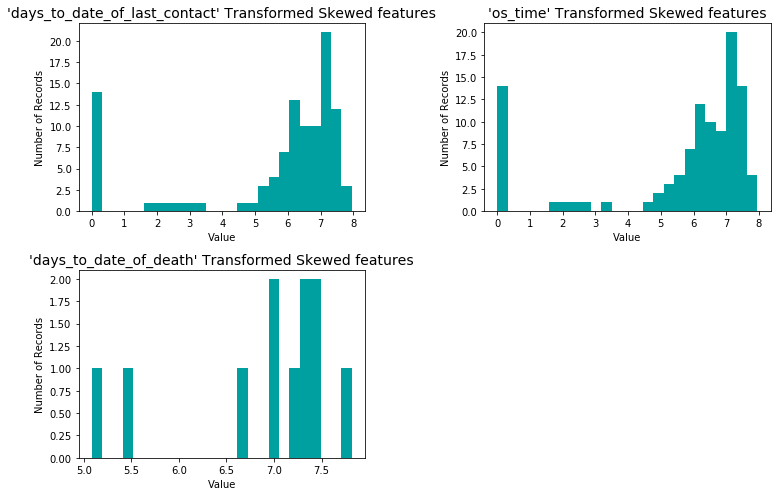

In [21]:
fig = pl.figure(figsize = (11,7));

# Overall survival plotting 
for i, feature in enumerate(['days_to_date_of_last_contact','os_time', 'days_to_date_of_death']):
        ax = fig.add_subplot(2, 2, i+1)
        ax.hist(features_log_transformed[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Transformed Skewed features"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        
fig.tight_layout()

In [22]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age_at_initial_pathologic_diagnosis'] 

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

/Users/andra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,complete_tcga_id,gender,age_at_initial_pathologic_diagnosis,er_status,pr_status,her2_final_status,tumor,node,node_coded,metastasis_coded,ajcc_stage,converted_stage,survival_data_form,vital_status,days_to_date_of_last_contact,days_to_date_of_death,os_time,rppa_clusters
0,TCGA-A2-A0T2,FEMALE,0.620690,Negative,Negative,Negative,T3,N3,Positive,Positive,Stage IV,No_Conversion,followup,DECEASED,5.484797,5.484797,5.484797,Basal
1,TCGA-A2-A0CM,FEMALE,0.172414,Negative,Negative,Negative,T2,N0,Negative,Negative,Stage IIA,Stage IIA,followup,DECEASED,6.626718,6.626718,6.626718,Basal
2,TCGA-BH-A18V,FEMALE,0.310345,Negative,Negative,Negative,T2,N1,Positive,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,7.349874,7.349874,7.349874,Basal
3,TCGA-BH-A18Q,FEMALE,0.448276,Negative,Negative,Negative,T2,N1,Positive,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,7.434257,7.434257,7.434257,Basal
4,TCGA-BH-A0E0,FEMALE,0.137931,Negative,Negative,Negative,T3,N3,Positive,Negative,Stage IIIC,No_Conversion,followup,LIVING,4.897840,NaN,4.897840,Basal


In [23]:
df=features_log_minmax_transform

# dropping further features that are not relevant
# Node - we keep node code; N0 is always negative, N1-3 is always positive 
# we keep vital status and overall survival time for cancer overall survival markers and remove days of last contact 
#and day to death as they are not relevant for assessing cancer sub type 
# we also drop gender because breast cancer affects females predominantely and we only have 2 records for males 
df=df.drop(['gender','survival_data_form','days_to_date_of_last_contact','converted_stage','days_to_date_of_death','node'], axis = 1)

In [24]:
display(df.head(n=5))

,complete_tcga_id,age_at_initial_pathologic_diagnosis,er_status,pr_status,her2_final_status,tumor,node_coded,metastasis_coded,ajcc_stage,vital_status,os_time,rppa_clusters
0,TCGA-A2-A0T2,0.620690,Negative,Negative,Negative,T3,Positive,Positive,Stage IV,DECEASED,5.484797,Basal
1,TCGA-A2-A0CM,0.172414,Negative,Negative,Negative,T2,Negative,Negative,Stage IIA,DECEASED,6.626718,Basal
2,TCGA-BH-A18V,0.310345,Negative,Negative,Negative,T2,Positive,Negative,Stage IIB,DECEASED,7.349874,Basal
3,TCGA-BH-A18Q,0.448276,Negative,Negative,Negative,T2,Positive,Negative,Stage IIB,DECEASED,7.434257,Basal
4,TCGA-BH-A0E0,0.137931,Negative,Negative,Negative,T3,Positive,Negative,Stage IIIC,LIVING,4.897840,Basal


At this point we have transformed our relevant numerical features and most of the other ones have binary categories with a few exceptions. 

Text(0.5, 1.0, 'Occurences of cancer stages')

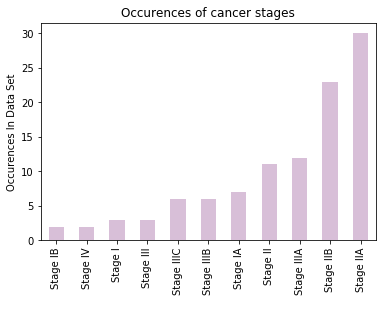

In [25]:


target_counts= df['ajcc_stage'].value_counts(ascending=True)

target_counts =  target_counts.plot(kind='bar', color = '#D8BFD8')
target_counts.set_xlabel(" ")
target_counts.set_ylabel("Occurences In Data Set")
target_counts.set_title("Occurences of cancer stages")



['Stage I' 'Stage II' 'Stage III-IV']


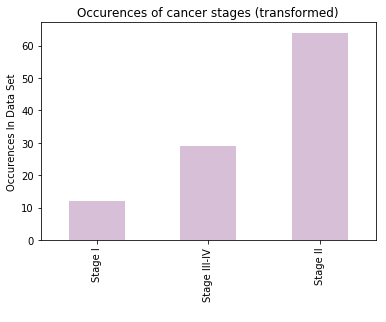

In [26]:
# transform the cancer stage variable 
import re

def clean_stages(x):
    replaced = re.sub('[ABC]', '', x)
    return (replaced)


def group_3_4(x):
    if (x=="Stage IV"): x="Stage III-IV"
    if (x=="Stage III"): x="Stage III-IV"   
    return (x)

df['ajcc_stage'] =df['ajcc_stage'].apply(lambda x: clean_stages(x))
df['ajcc_stage'] =df['ajcc_stage'].apply(lambda x: group_3_4(x))

target_counts= df['ajcc_stage'].value_counts(ascending=True)
target_counts =  target_counts.plot(kind='bar', color = '#D8BFD8')
target_counts.set_xlabel(" ")
target_counts.set_ylabel("Occurences In Data Set")
target_counts.set_title("Occurences of cancer stages (transformed)")
print(unique(df['ajcc_stage']))


Text(0.5, 1.0, 'Occurences of rppa cluster types')

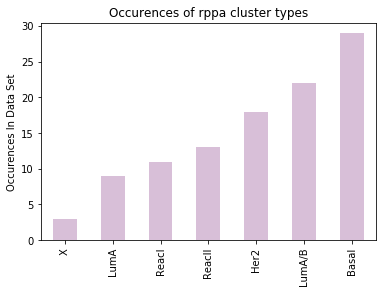

In [27]:

target_counts= df['rppa_clusters'].value_counts(ascending=True)

target_counts =  target_counts.plot(kind='bar', color = '#D8BFD8')
target_counts.set_xlabel(" ")
target_counts.set_ylabel("Occurences In Data Set")
target_counts.set_title("Occurences of rppa cluster types")



Text(0.5, 1.0, 'Occurences of code tumor types')

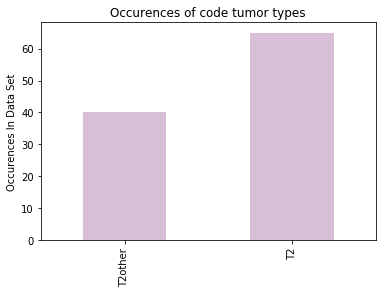

In [28]:


def code_tumor(x):
    #replaced = re.sub('[T1]', 'T2other', x)
    if (x=="T1")  or (x=="T3") or (x=="T4") : x="T2other"
    return (x)

#code_tumor("T3")

df['tumor'] =df['tumor'].apply(lambda x: code_tumor(x))

target_counts= df['tumor'].value_counts(ascending=True)

target_counts =  target_counts.plot(kind='bar', color = '#D8BFD8')
target_counts.set_xlabel(" ")
target_counts.set_ylabel("Occurences In Data Set")
target_counts.set_title("Occurences of code tumor types")


### 2.2 Descriptive analysis and feature engineering on the expression data set 

In [29]:

#expression_data=pd.read_csv("77_cancer_proteomes_CPTAC_itraq.csv")
display(expression_data.head(n=5))

,RefSeq_accession_number,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
0,NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
1,NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
2,NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
3,NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
4,NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [30]:
expression_data['gene_symbol'].fillna("NA",inplace = True)

#create unique identifier using the available gene information to be used as column name 

expression_data['complete_tcga_id'] = expression_data['RefSeq_accession_number'] + " - " + expression_data['gene_name'].map(str) + " - " + \
                    expression_data['gene_symbol']
expression_data = expression_data.set_index('complete_tcga_id')

#remove extra gene information 
expression_data2 = expression_data.drop(['gene_name','gene_symbol','RefSeq_accession_number'],1)

# we aim to use the molecular signatures after the clustering in the classification model so we need to transpose the data
#so that it has unique ids as columns in order to be merged with the clinical data later on 

expression_data_3 = expression_data2.dropna(axis = 0)
expression_data_3 = expression_data2.transpose()

#expression_data_2['gene_symbol']


In [31]:

def id_mapping(x):
    y=x.replace("TCGA","")
    y="TCGA-"+y
    rest = y.split(".", 1)[0]
    return (rest)

expression_data_4=expression_data_3
expression_data_4.index = expression_data_4.index.to_series().apply(id_mapping)
display(expression_data_4.head(n=5))



complete_tcga_id,NP_958782 - plectin isoform 1 - PLEC,NP_958785 - plectin isoform 1g - NA,NP_958786 - plectin isoform 1a - PLEC,NP_000436 - plectin isoform 1c - NA,NP_958781 - plectin isoform 1e - NA,NP_958780 - plectin isoform 1f - PLEC,NP_958783 - plectin isoform 1d - PLEC,NP_958784 - plectin isoform 1b - NA,NP_112598 - epiplakin - NA,NP_001611 - neuroblast differentiation-associated protein AHNAK isoform 1 - AHNAK,...,NP_001193600 - protein RIC-3 isoform c precursor - NA,NP_061134 - basic leucine zipper transcriptional factor ATF-like 3 - BATF3,NP_932347 - sex comb on midleg-like protein 4 - SCML4,NP_003593 - peptidyl-prolyl cis-trans isomerase FKBP6 isoform a - FKBP6,NP_997203 - OTU domain-containing protein 6A - OTUD6A,NP_001191293 - protein FAM24B precursor - NA,NP_775791 - putative uncharacterized protein C9orf62 - NA,"NP_004065 - cytochrome c oxidase subunit 8A, mitochondrial - COX8A",NP_068752 - migration and invasion-inhibitory protein - MIIP,NP_219494 - uncharacterized protein KIAA1737 - KIAA1737
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,...,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,...,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,...,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,NaN,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,NaN,-0.047997


In [32]:
#display(expression_data_4.describe())

In [33]:
expression_data_4.index.value_counts().head() #duplicates 

TCGA-C8-A131    2
TCGA-AO-A12B    2
TCGA-AO-A12D    2
TCGA-AR-A0TX    1
TCGA-E2-A154    1
dtype: int64

In [34]:
expression_data_4 = expression_data_4.sort_index()

expression_data_4 = expression_data_4.loc[~expression_data_4.index.duplicated(keep='first')]#dropping duplicates indices

In [35]:
expression_data_4.index.value_counts().head() #viewing dropped indices 

TCGA-A2-A0YM     1
TCGA-AR-A0TT     1
TCGA-BH-A0DG     1
TCGA-c4155b-C    1
TCGA-AN-A0AJ     1
dtype: int64

In [36]:
expression_data_4.shape


(80, 12553)

In [37]:
missing_data_maps= expression_data_4.isnull().mean() * 100
missing_data_maps=pd.DataFrame(missing_data_maps)

In [38]:
#drop columns that have a high level of missing protein expression data 
expression_data_4.drop(missing_data_maps.loc[missing_data_maps[0] > 20].axes[0].tolist(), axis=1,inplace=True)

# impute protein data with median value data 
imputed=expression_data_4.fillna(expression_data_4.median())



In [39]:
# check how many PAM50 proteins are included in the expression data 
display(imputed.head(n=5))
display(mapping_proteins.head(n=5))

complete_tcga_id,NP_958782 - plectin isoform 1 - PLEC,NP_958785 - plectin isoform 1g - NA,NP_958786 - plectin isoform 1a - PLEC,NP_000436 - plectin isoform 1c - NA,NP_958781 - plectin isoform 1e - NA,NP_958780 - plectin isoform 1f - PLEC,NP_958783 - plectin isoform 1d - PLEC,NP_958784 - plectin isoform 1b - NA,NP_112598 - epiplakin - NA,NP_001611 - neuroblast differentiation-associated protein AHNAK isoform 1 - AHNAK,...,NP_002460 - myogenic factor 6 - MYF6,NP_001092808 - NUT family member 2A - FAM22A,NP_000610 - interferon gamma precursor - IFNG,NP_699178 - lysoplasmalogenase-like protein TMEM86A - TMEM86A,NP_006140 - galectin-4 - LGALS4,NP_068835 - urotensin-2 isoform a preproprotein - UTS2,NP_612382 - myeloid-associated differentiation marker - MYADM,NP_848561 - BPI fold-containing family A member 3 isoform 1 precursor - C20ORF71,NP_665813 - voltage-dependent calcium channel gamma-6 subunit isoform a - CACNG6,NP_001193600 - protein RIC-3 isoform c precursor - NA
TCGA-263d3f-I,0.598585,0.606697,0.603993,0.603993,0.603993,0.606697,0.603993,0.603993,-0.602132,2.778263,...,-0.429056,0.368718,-5.048028,-0.915833,3.584150,-2.865645,-0.814504,-0.577605,0.476942,-2.162522
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,0.055601,1.212390,-0.381916,1.557701,3.335683,-0.910903,-0.954985,-0.841106,-1.101926,-1.065178
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,0.669655,-0.245109,-2.074637,1.271736,2.229743,-0.211845,-0.018913,0.589821,3.230994,0.919136
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,-2.148822,1.211367,-2.229191,1.035321,1.383586,0.507182,-3.377319,-0.577605,-1.077235,-0.801685
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,-0.104334,-1.207770,-7.399899,0.702239,-1.546643,-0.681257,-1.020130,-1.832304,-0.504820,-4.966177


,genesymbol,RefSeq_accession_number,species,gene_name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
1,FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
2,FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
3,FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
4,GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160


In [40]:
pam50refseq=mapping_proteins.RefSeq_accession_number.unique()
pam50_expr=imputed
print(pam50_expr.shape)

(80, 10062)


In [41]:
# keeping only the proteins which can be retrieved in the pam50 data set 
i=0
for (columnName, columnData) in imputed.items():
    x=columnName.split("-")[0].strip()
    if x not in pam50refseq: 
        pam50_expr.drop([columnName],1, inplace=True)
        i=i+1
print(i)
pam50_expr.shape

10027


(80, 35)

In [42]:
display(pam50_expr.head(n=5))


complete_tcga_id,NP_057427 - centromere protein F - CENPF,NP_002408 - antigen KI-67 isoform 1 - MKI67,"NP_000415 - keratin, type II cytoskeletal 5 - KRT5","NP_000413 - keratin, type I cytoskeletal 17 - NA","NP_000517 - keratin, type I cytoskeletal 14 - KRT14",NP_004439 - receptor tyrosine-protein kinase erbB-2 isoform a precursor - ERBB2,NP_005219 - epidermal growth factor receptor isoform a precursor - EGFR,NP_058519 - microtubule-associated protein tau isoform 1 - NA,NP_058518 - microtubule-associated protein tau isoform 3 - MAPT,NP_001116539 - microtubule-associated protein tau isoform 5 - MAPT,...,NP_003003 - secreted frizzled-related protein 1 precursor - SFRP1,NP_113611 - kinetochore protein Nuf2 - NUF2,NP_002002 - fibroblast growth factor receptor 4 isoform 1 precursor - FGFR4,NP_004487 - hepatocyte nuclear factor 3-alpha - FOXA1,NP_008950 - ubiquitin-conjugating enzyme E2 C isoform 1 - UBE2C,NP_114172 - G2/mitotic-specific cyclin-B1 - CCNB1,NP_001062 - thymidylate synthase - TYMS,NP_057547 - CXXC-type zinc finger protein 5 - CXXC5,NP_054895 - ubiquitin-conjugating enzyme E2 T - UBE2T,NP_001246 - cell division cycle protein 20 homolog - CDC20
TCGA-263d3f-I,-0.905015,-3.401099,2.897253,2.299599,2.405068,-1.951586,0.333562,-1.021301,-1.086205,-1.032118,...,5.720560,-0.010266,0.644558,0.855495,-1.472922,-2.254469,-3.425438,1.604590,-0.756278,-0.640522
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,0.286664,0.980958,1.509945,-4.433806,2.549550,2.733226,0.896468,-1.292949,3.541400,3.177722
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,7.053044,2.921637,3.743262,-6.269245,2.376105,2.781928,6.836827,-3.694601,2.495856,2.722053
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,...,-5.554936,0.047930,3.388984,0.063239,0.545453,-0.273546,1.460128,-1.410193,0.702364,-1.402538
TCGA-A2-A0EV,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,...,1.080321,-0.709263,-1.199369,-1.723081,-2.179579,-3.311022,0.139319,0.018893,-1.574649,-4.515280


In [43]:
#pam50_expr.shape
#expression_data_4.shape

imputed=expression_data_4.fillna(expression_data_4.median())

imputed.shape
display(pam50_expr.head(n=4))

complete_tcga_id,NP_057427 - centromere protein F - CENPF,NP_002408 - antigen KI-67 isoform 1 - MKI67,"NP_000415 - keratin, type II cytoskeletal 5 - KRT5","NP_000413 - keratin, type I cytoskeletal 17 - NA","NP_000517 - keratin, type I cytoskeletal 14 - KRT14",NP_004439 - receptor tyrosine-protein kinase erbB-2 isoform a precursor - ERBB2,NP_005219 - epidermal growth factor receptor isoform a precursor - EGFR,NP_058519 - microtubule-associated protein tau isoform 1 - NA,NP_058518 - microtubule-associated protein tau isoform 3 - MAPT,NP_001116539 - microtubule-associated protein tau isoform 5 - MAPT,...,NP_003003 - secreted frizzled-related protein 1 precursor - SFRP1,NP_113611 - kinetochore protein Nuf2 - NUF2,NP_002002 - fibroblast growth factor receptor 4 isoform 1 precursor - FGFR4,NP_004487 - hepatocyte nuclear factor 3-alpha - FOXA1,NP_008950 - ubiquitin-conjugating enzyme E2 C isoform 1 - UBE2C,NP_114172 - G2/mitotic-specific cyclin-B1 - CCNB1,NP_001062 - thymidylate synthase - TYMS,NP_057547 - CXXC-type zinc finger protein 5 - CXXC5,NP_054895 - ubiquitin-conjugating enzyme E2 T - UBE2T,NP_001246 - cell division cycle protein 20 homolog - CDC20
TCGA-263d3f-I,-0.905015,-3.401099,2.897253,2.299599,2.405068,-1.951586,0.333562,-1.021301,-1.086205,-1.032118,...,5.720560,-0.010266,0.644558,0.855495,-1.472922,-2.254469,-3.425438,1.604590,-0.756278,-0.640522
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,0.286664,0.980958,1.509945,-4.433806,2.549550,2.733226,0.896468,-1.292949,3.541400,3.177722
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,7.053044,2.921637,3.743262,-6.269245,2.376105,2.781928,6.836827,-3.694601,2.495856,2.722053
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,...,-5.554936,0.047930,3.388984,0.063239,0.545453,-0.273546,1.460128,-1.410193,0.702364,-1.402538


## 3. Clustering on the expression data set 

### 3.1 PAM50 relevant proteins

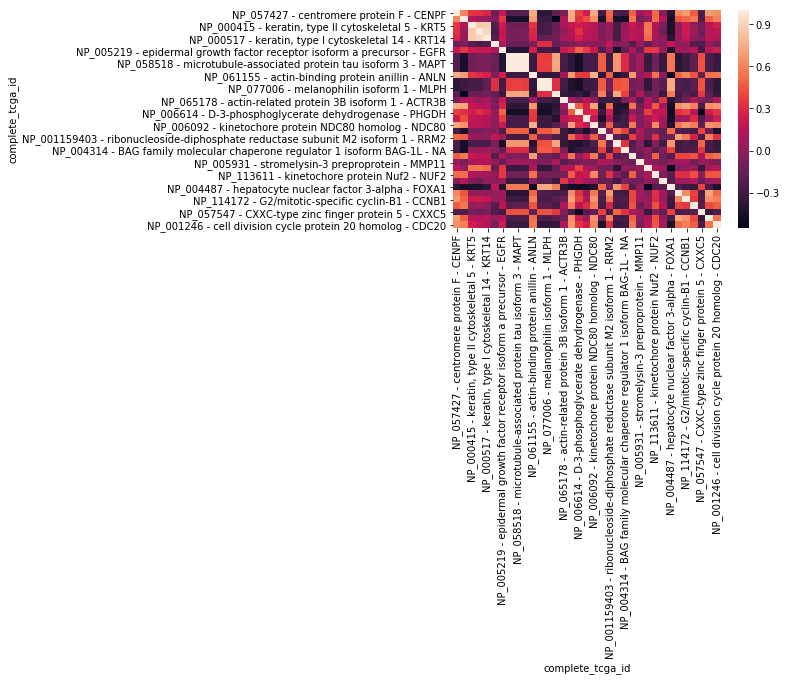

In [45]:
import seaborn as sb

# visualise correlations in the expression data set 

pam50_expr.corr()
sb.heatmap(pam50_expr.corr())

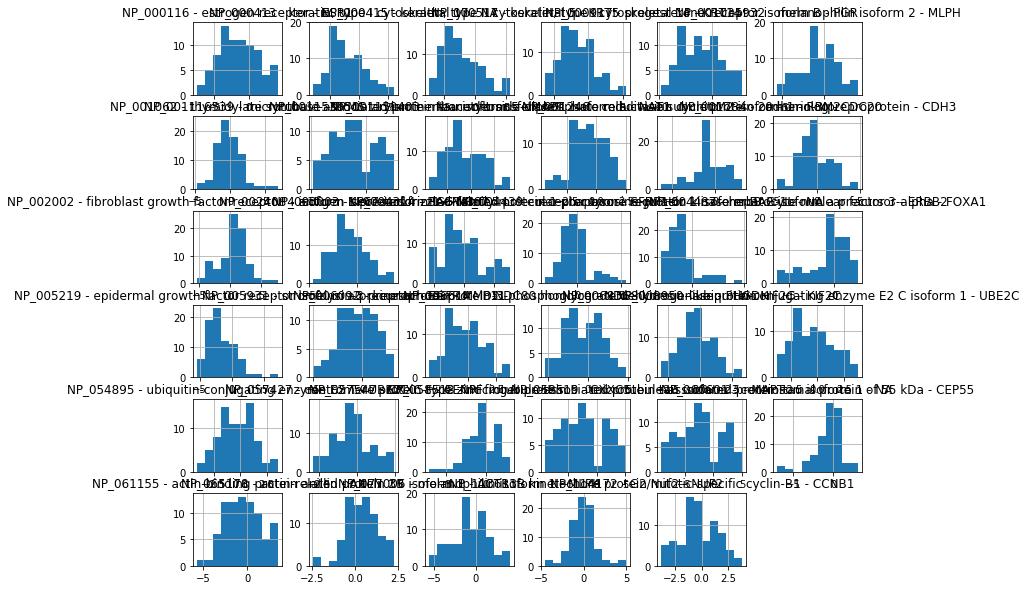

In [49]:
pam50_expr.hist(figsize=(12, 10)); #visualise distribution for the PAM50 relevant proteins 

In [59]:
molecular_df=molecular_df.reset_index()

molecular_df = molecular_df.set_index('complete_tcga_id') # set patient id as index 
display(molecular_df.head(n=5))

#display(pam50_expr.head(n=5))

,sigclust_unsupervised_mrna,sigclust_intrinsic_mrna,mirna_clusters,methylation_clusters,cn_clusters,integrated_clusters_(with_pam50),integrated_clusters_(no_exp),integrated_clusters_(unsup_exp)
complete_tcga_id,,,,,,,,
TCGA-A2-A0T2,0,-13,3,5,3,2,2,2
TCGA-A2-A0CM,-12,-13,4,4,4,2,1,1
TCGA-BH-A18V,-12,-13,5,5,1,2,2,2
TCGA-BH-A18Q,-12,-13,5,5,1,2,2,2
TCGA-BH-A0E0,0,-13,5,5,1,2,2,2


In [61]:

merged_pam50 = pd.concat([pam50_expr, molecular_df], axis=1, join='inner') #join expression and molecular data 
#display(merged_pam50.tail(n=5))

merged_all = pd.concat([imputed, molecular_df], axis=1, join='inner')

#merged_all.shape

display(merged_pam50.tail(n=5))



,NP_057427 - centromere protein F - CENPF,NP_002408 - antigen KI-67 isoform 1 - MKI67,"NP_000415 - keratin, type II cytoskeletal 5 - KRT5","NP_000413 - keratin, type I cytoskeletal 17 - NA","NP_000517 - keratin, type I cytoskeletal 14 - KRT14",NP_004439 - receptor tyrosine-protein kinase erbB-2 isoform a precursor - ERBB2,NP_005219 - epidermal growth factor receptor isoform a precursor - EGFR,NP_058519 - microtubule-associated protein tau isoform 1 - NA,NP_058518 - microtubule-associated protein tau isoform 3 - MAPT,NP_001116539 - microtubule-associated protein tau isoform 5 - MAPT,...,NP_054895 - ubiquitin-conjugating enzyme E2 T - UBE2T,NP_001246 - cell division cycle protein 20 homolog - CDC20,sigclust_unsupervised_mrna,sigclust_intrinsic_mrna,mirna_clusters,methylation_clusters,cn_clusters,integrated_clusters_(with_pam50),integrated_clusters_(no_exp),integrated_clusters_(unsup_exp)
TCGA-C8-A138,-0.409316,0.739026,0.943825,1.415596,1.806910,-0.504402,-2.625542,-5.284283,-4.907597,-5.309883,...,-0.295945,-2.307371,-5,-2,1,2,2,1,3,2
TCGA-D8-A142,-0.415696,-1.232627,-2.823113,1.724231,0.668726,-3.130366,-0.462687,-6.427009,-6.195666,-6.427009,...,-1.232627,-1.438667,0,-13,3,5,1,2,2,2
TCGA-E2-A154,-2.742664,-3.307172,-5.903908,-5.218972,-4.650701,-3.894260,-3.284592,2.861017,3.098110,2.981445,...,-2.772771,-6.268957,-3,-12,6,4,2,3,3,3
TCGA-E2-A158,-0.781777,-1.588474,-3.732945,0.701651,0.213150,-2.531862,-0.277591,-4.456732,-4.665129,-4.665129,...,-0.183476,-0.732478,0,-13,5,5,1,2,2,2
TCGA-E2-A15A,0.229658,-0.441373,-1.183981,-2.951031,-1.649230,-4.682292,-5.152014,-4.158888,-4.673345,-4.364671,...,0.140188,-2.655777,-5,-2,4,4,4,4,1,1


In [138]:
merged_pam50.shape

(77, 43)

### 3.2 PCA on molecular data - explaining 80% of variance

In [63]:
from sklearn.decomposition import PCA
# Apply PCA , ensuring that the components explain at least 80% of the variance in data 

pca = PCA(n_components=0.8).fit(merged_pam50)
reduced_data = pca.transform(merged_pam50)

reduced_data = pd.DataFrame(reduced_data)

display(reduced_data.head(n=5))

,0,1,2,3,4,5,6,7,8
0,16.698568,-6.179458,-6.176073,-1.646675,-1.053301,5.829104,0.271386,3.119147,3.105698
1,18.687097,-8.707609,-5.914208,-3.230280,-1.438870,4.381644,-4.257821,-2.988695,-1.268709
2,9.472921,14.938719,1.374566,-1.480265,0.307309,0.451698,-3.062276,2.306972,-4.624855
3,-4.837672,3.885557,1.253379,6.028322,-4.100318,-1.932558,-4.530099,-3.857755,-1.057162
4,-10.131031,-5.200370,1.008929,2.843785,-6.013721,2.654309,2.811020,-3.779747,-2.283331


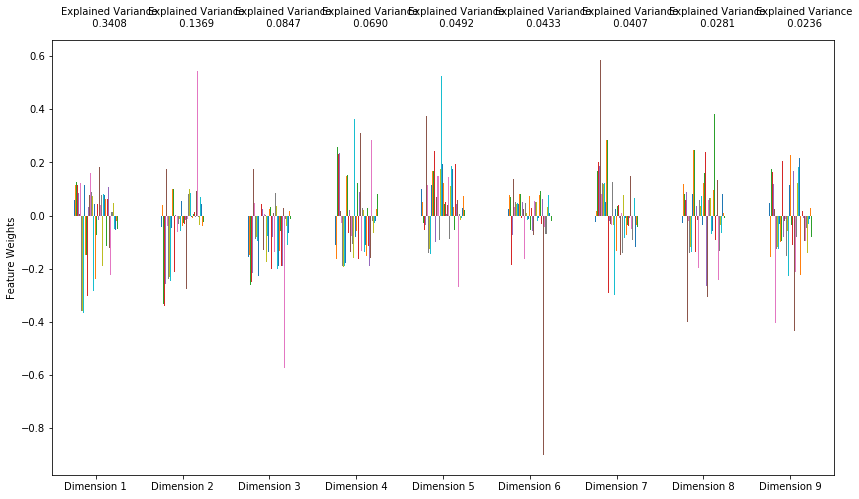

In [64]:
## Adapted from the visuals file 
# Generate PCA results plot
pca_results = vs1.pca_results(merged_pam50, pca)

In [65]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

for n_clusters in range(2,20):
    clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)
    preds = clusterer.predict(reduced_data)

    centers_trial = clusterer.means_

    sample_preds_trial = clusterer.predict(reduced_data)

    score = silhouette_score(reduced_data, preds)
    print("Number of clusters",n_clusters," Score ", round(score,3))
    


Number of clusters 2  Score  0.264
Number of clusters 3  Score  0.182
Number of clusters 4  Score  0.164
Number of clusters 5  Score  0.192
Number of clusters 6  Score  0.153
Number of clusters 7  Score  0.182
Number of clusters 8  Score  0.196
Number of clusters 9  Score  0.155
Number of clusters 10  Score  0.188
Number of clusters 11  Score  0.192
Number of clusters 12  Score  0.173
Number of clusters 13  Score  0.157
Number of clusters 14  Score  0.145
Number of clusters 15  Score  0.153
Number of clusters 16  Score  0.147
Number of clusters 17  Score  0.143
Number of clusters 18  Score  0.179
Number of clusters 19  Score  0.136


In [77]:
from sklearn.cluster import KMeans
from sklearn import metrics


for n_clusters in range(2,20):
    clusterer = KMeans(n_clusters=n_clusters, n_jobs=4)
    clusterer.fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    score = metrics.silhouette_score(reduced_data, preds)
    print("Number of clusters",n_clusters," Silhouette Score ", round(score,3))

Number of clusters 2  Silhouette Score  0.269
Number of clusters 3  Silhouette Score  0.228
Number of clusters 4  Silhouette Score  0.2
Number of clusters 5  Silhouette Score  0.193
Number of clusters 6  Silhouette Score  0.192
Number of clusters 7  Silhouette Score  0.194
Number of clusters 8  Silhouette Score  0.186
Number of clusters 9  Silhouette Score  0.196
Number of clusters 10  Silhouette Score  0.191
Number of clusters 11  Silhouette Score  0.187
Number of clusters 12  Silhouette Score  0.187
Number of clusters 13  Silhouette Score  0.197
Number of clusters 14  Silhouette Score  0.188
Number of clusters 15  Silhouette Score  0.193
Number of clusters 16  Silhouette Score  0.156
Number of clusters 17  Silhouette Score  0.171
Number of clusters 18  Silhouette Score  0.175
Number of clusters 19  Silhouette Score  0.176


In [78]:
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
from itertools import cycle

dampings=[0.5,0.6,0.7,0.8,0.9]
for n_damping in dampings:
    af = AffinityPropagation(affinity='euclidean',damping=n_damping,max_iter=1000).fit(reduced_data)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_

    n_clusters = len(cluster_centers_indices)
    score = metrics.silhouette_score(reduced_data, af.labels_)
    print("Damping", n_damping,"Number of clusters",n_clusters," Score: ", round(score,3))


Damping 0.5 Number of clusters 8  Score:  0.179
Damping 0.6 Number of clusters 8  Score:  0.179
Damping 0.7 Number of clusters 8  Score:  0.179
Damping 0.8 Number of clusters 7  Score:  0.167
Damping 0.9 Number of clusters 7  Score:  0.167


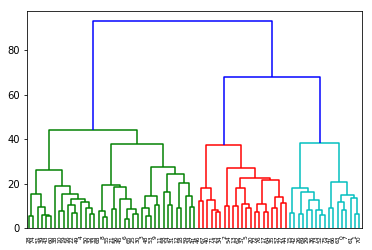

In [79]:
import scipy.cluster.hierarchy as hh
from sklearn.cluster import AgglomerativeClustering

dendrogram = hh.dendrogram(hh.linkage(reduced_data, method='ward'))
clusterer = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'ward')
fits = clusterer.fit_predict(reduced_data)

Winner model GMM - as the score between the 2 and 3 clusters scenario is more well defined. 

In [80]:
n_clusters=2
clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers_trial = clusterer.means_
score = silhouette_score(reduced_data, preds)
print("Number of clusters",n_clusters," Score ", round(score,3))
    

Number of clusters 2  Score  0.264


In [81]:
mol_sign_df=pd.DataFrame(merged_pam50.index)
mol_sign_df.columns=['complete_tcga_id']
mol_sign_df['signature']=preds

#display(merged_pam50.tail(n=3))

In [82]:
display(mol_sign_df.head(n=3)) # to be merged with the clinical data set 

,complete_tcga_id,signature
0,TCGA-A2-A0CM,1
1,TCGA-A2-A0D2,1
2,TCGA-A2-A0EQ,1


## 4. Classification of cancer subtype using expression data clusters 

Preparation for classification:

- Collecting all data together (detected molecular signatures+ clinical data) 
- One-hot encoding for the categorical variables

Classification
- Dummy Classifier implementation
- Classification with multiple algorithms & map performance 
- Select several that are better performing and run optimisation 

In [86]:
# collecting all data in a final data frame 

mol_sign_df=mol_sign_df.set_index('complete_tcga_id')
df=df.set_index('complete_tcga_id')
cancer_type=cancer_type.set_index("complete_tcga_id")

final_df=pd.merge(mol_sign_df, df, left_index=True, right_index=True)
#display(final_df.head(n=5))

final_df=pd.merge(final_df, cancer_type, left_index=True, right_index=True)
#display(final_df.head(n=5))

final_df=final_df.reset_index()
#display(final_df.head(n=5))

final_features = final_df.drop(['pam50_mrna'], axis = 1) 
# drop also tcga id
final_features = final_features.drop(['complete_tcga_id'], axis = 1) 

display(final_features.head(n=3))

,signature,age_at_initial_pathologic_diagnosis,er_status,pr_status,her2_final_status,tumor,node_coded,metastasis_coded,ajcc_stage,vital_status,os_time,rppa_clusters
0,1,0.172414,Negative,Negative,Negative,T2,Negative,Negative,Stage II,DECEASED,6.626718,Basal
1,1,0.258621,Negative,Negative,Negative,T2,Negative,Negative,Stage II,LIVING,6.935370,Basal
2,1,0.586207,Negative,Negative,Positive,T2,Negative,Negative,Stage II,LIVING,7.794411,Basal


### One hot encoding on the final data set 

In [87]:
final_features2 = pd.get_dummies(final_features)
print("{} total features after one-hot encoding.".format(len(final_features2.columns)))

28 total features after one-hot encoding.


In [88]:
display(final_features2.head(n=3))

,signature,age_at_initial_pathologic_diagnosis,os_time,er_status_Negative,er_status_Positive,pr_status_Negative,pr_status_Positive,her2_final_status_Equivocal,her2_final_status_Negative,her2_final_status_Positive,...,ajcc_stage_Stage III-IV,vital_status_DECEASED,vital_status_LIVING,rppa_clusters_Basal,rppa_clusters_Her2,rppa_clusters_LumA,rppa_clusters_LumA/B,rppa_clusters_ReacI,rppa_clusters_ReacII,rppa_clusters_X
0,1,0.172414,6.626718,1,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
1,1,0.258621,6.935370,1,0,1,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
2,1,0.586207,7.794411,1,0,1,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0


In [91]:
# Encode the target variables into numerical 

target= final_df['pam50_mrna']
def target_mapping(x):
    y=None
    if (x=='Basal-like'): y=0
    if (x=='HER2-enriched'): y=1
    if (x=="Luminal A"): y=2
    if (x=="Luminal B"): y=3
    return (y)

#  Encode the 'pam50 mrna' data to numerical values
target = target.apply(lambda x: target_mapping(x))
print(target[1:6])

1    0
2    1
3    2
4    2
5    3
Name: pam50_mrna, dtype: int64


### Shuffle data set

In [92]:
final_features3 = final_features2[final_features2.columns.drop(list(final_features2.filter(regex='rppa')))]
#final_features3 = final_features3[final_features3.columns.drop(list(final_features3.filter(regex='ajcc')))]

#final_features3 = final_features3[final_features3.columns.drop(list(final_features3.filter(regex='vital')))]
#final_features3 = final_features3[final_features3.columns.drop(list(final_features3.filter(regex='os_time')))]

#final_feature3=final_features2
display(final_features3.head(n=5))

,signature,age_at_initial_pathologic_diagnosis,os_time,er_status_Negative,er_status_Positive,pr_status_Negative,pr_status_Positive,her2_final_status_Equivocal,her2_final_status_Negative,her2_final_status_Positive,...,tumor_T2other,node_coded_Negative,node_coded_Positive,metastasis_coded_Negative,metastasis_coded_Positive,ajcc_stage_Stage I,ajcc_stage_Stage II,ajcc_stage_Stage III-IV,vital_status_DECEASED,vital_status_LIVING
0,1,0.172414,6.626718,1,0,1,0,0,1,0,...,0,1,0,1,0,0,1,0,1,0
1,1,0.258621,6.935370,1,0,1,0,0,1,0,...,0,1,0,1,0,0,1,0,0,1
2,1,0.586207,7.794411,1,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,1
3,0,0.862069,6.876265,0,1,0,1,0,1,0,...,1,1,0,1,0,1,0,0,0,1
4,0,0.275862,6.309918,0,1,0,1,0,1,0,...,1,1,0,1,0,0,1,0,0,1


In [93]:
# Import train_test_split

from sklearn.model_selection import train_test_split

#final_features3 = df[df.columns.drop(list(df.filter(regex='Test')))]


# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_features3, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 61 samples.
Testing set has 16 samples.


### Benchmark model - dummy classifier 

In [94]:
from sklearn.dummy import DummyClassifier

# adapted from : https://www.geeksforgeeks.org/ml-dummy-classifiers-using-sklearn/

strategies = ['most_frequent', 'stratified', 'uniform']
  
test_scores = [] 
for s in strategies: 
    if s =='constant': 
        dclf = DummyClassifier(strategy = s, random_state = 0, constant ='M') 
    else: 
        dclf = DummyClassifier(strategy = s, random_state = 0) 
    dclf.fit(X_train, y_train) 
    score = dclf.score(X_test, y_test) 
    test_scores.append(score) 

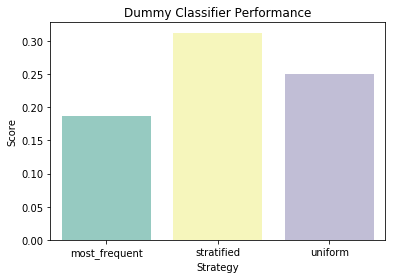

In [95]:
sb.set_palette("Set3")
barplot = sb.barplot(x = strategies, y = test_scores)
barplot.set(xlabel = "Strategy", ylabel = "Score", title = "Dummy Classifier Performance")
plt.show()

In [96]:
print("F score for winner model {} ".format(test_scores[1]))

F score for winner model 0.3125 


We select the Dummy Classifier with stratified strategy as our benchmark model with an F score = 0.3125

In [141]:
# scorer function 
# adapted from Udacity - Finding donors
from sklearn.metrics import fbeta_score, accuracy_score

def scorer( predictions_train, predictions_test, X_train, y_train, X_test, y_test): 

    results = {}
    results['acc_train'] = round(metrics.accuracy_score(y_train[:10], predictions_train[:10]),3)
    results['acc_test'] = round(metrics.accuracy_score(y_test, predictions_test),3)
    results['balanced_accuracy_test']=metrics.balanced_accuracy_score(y_test, predictions_test)
    results['f_beta_train'] = round(fbeta_score(y_train[:10],predictions_train[:10], average='macro', beta=0.5),3)
    results['f_beta_test'] = round(fbeta_score(y_test,predictions_test, average='macro', beta=0.5),6)
    results['f_1_train'] = round(metrics.f1_score(y_train[:10],predictions_train[:10], average='macro'),3)
    results['f_1_test'] = round(metrics.f1_score(y_test,predictions_test, average='macro'),3)

    # Return the results
    return results

### Classification models - non optimised

In [142]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz



warnings.filterwarnings(action='once')

models=['Decision Tree',"Ada Boost","Logistic regression","Random Forrest","Naive Bayes", "XGBoost","SVM"]

model_results={}

for model in models: 
    print (model)
    
    if (model=='Decision Tree') : 
        clf= DecisionTreeClassifier( random_state=123)
        clf = clf.fit(X_train,y_train)
        predictions_train=clf.predict(X_train)
        predictions_test = clf.predict(X_test)
        score=scorer(predictions_train=predictions_train, predictions_test=predictions_test, X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test)
       # print(score)
        model_results[model]=score
        
    if (model=='Ada Boost') : 
        clf= AdaBoostClassifier(random_state=123)
        clf = clf.fit(X_train,y_train) 
        predictions_train=clf.predict(X_train)
        predictions_test = clf.predict(X_test)
        score=scorer(predictions_train=predictions_train, predictions_test=predictions_test, X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test)
      #  print (score)
        model_results[model]=score
    if (model=="Logistic regression"):
        clf= LogisticRegression(solver='lbfgs', random_state=123, multi_class='auto', max_iter=5000)
        clf = clf.fit(X_train,y_train)
        predictions_train=clf.predict(X_train)
        predictions_test = clf.predict(X_test)
        score=scorer(predictions_train=predictions_train, predictions_test=predictions_test, X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test)
      #  print (score)
        model_results[model]=score
        
    if (model=="Random Forrest"):
        clf= RandomForestClassifier(random_state=123)
        clf = clf.fit(X_train,y_train)
        predictions_train=clf.predict(X_train)
        predictions_test = clf.predict(X_test)
        score=scorer(predictions_train=predictions_train, predictions_test=predictions_test, X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test)
       # print (score)
        model_results[model]=score
    
    if (model=="Naive Bayes"):
        clf= GaussianNB()
        clf = clf.fit(X_train,y_train)
        predictions_train=clf.predict(X_train)
        predictions_test = clf.predict(X_test)
        score=scorer(predictions_train=predictions_train, predictions_test=predictions_test, X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test)
       # print (score)
        model_results[model]=score
        
    if (model=="XGBoost"):
        clf= GradientBoostingClassifier()
        clf = clf.fit(X_train,y_train)
        predictions_train=clf.predict(X_train)
        predictions_test = clf.predict(X_test)
        score=scorer(predictions_train=predictions_train, predictions_test=predictions_test, X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test)
       # print (score)
        model_results[model]=score
        
    if (model=="SVM"):
        clf= SVC(random_state=123)
        clf = clf.fit(X_train,y_train)
        predictions_train=clf.predict(X_train)
        predictions_test = clf.predict(X_test)
        score=scorer(predictions_train=predictions_train, predictions_test=predictions_test, X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test)
       # print (score)
        model_results[model]=score

pd.DataFrame(model_results)




Decision Tree
Ada Boost
Logistic regression


/Users/andra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/andra/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forrest
Naive Bayes
XGBoost
SVM


/Users/andra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,Decision Tree,Ada Boost,Logistic regression,Random Forrest,Naive Bayes,XGBoost,SVM
acc_test,0.688000,0.750000,0.562000,0.688000,0.562000,0.625000,0.438000
acc_train,1.000000,0.700000,0.800000,0.900000,0.800000,1.000000,0.800000
balanced_accuracy_test,0.684524,0.625000,0.565476,0.636905,0.517857,0.601190,0.419643
f_1_test,0.694000,0.623000,0.597000,0.667000,0.560000,0.633000,0.412000
f_1_train,1.000000,0.593000,0.875000,0.937000,0.806000,1.000000,0.875000
f_beta_test,0.736111,0.644504,0.643519,0.702694,0.601190,0.673971,0.415675
f_beta_train,1.000000,0.585000,0.875000,0.943000,0.806000,1.000000,0.875000


### Visualising and optimising the Decision Tree Classifier 


In [143]:
clf= DecisionTreeClassifier( random_state=123)
clf = clf.fit(X_train,y_train)
predictions_train=clf.predict(X_train)
predictions_test = clf.predict(X_test)
score=scorer(predictions_train=predictions_train, predictions_test=predictions_test, X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test)
       

In [144]:
print("Accuracy on test:", round(score['acc_test'],2))

Accuracy on test: 0.69


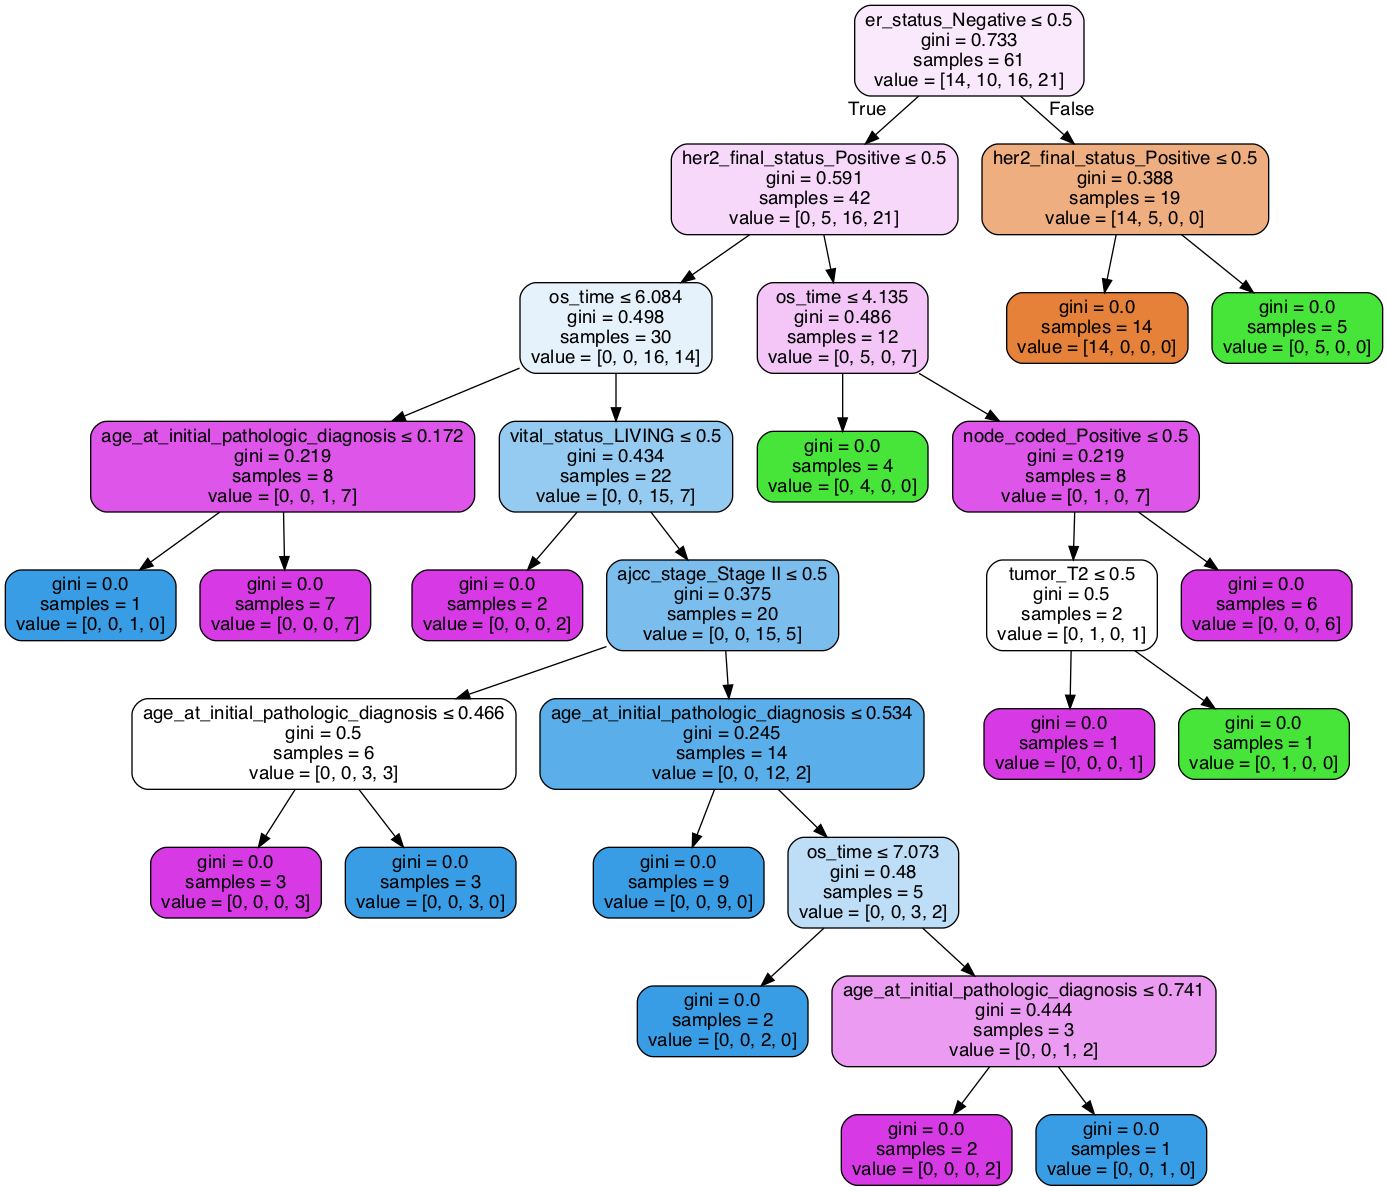

In [145]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

#Visualisation adapted from https://www.datacamp.com/community/tutorials/decision-tree-classification-python

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = final_features3.columns)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = final_features3.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('unoptimised_tree.png')
Image(graph.create_png())


In [146]:
clf_entropy = DecisionTreeClassifier( 
            criterion="entropy", random_state = 123, 
            max_depth = 5, min_samples_leaf =3)

In [147]:
clf_entropy = clf_entropy.fit(X_train,y_train)
predictions_train=clf_entropy.predict(X_train)
predictions_test = clf_entropy.predict(X_test)
score=scorer(predictions_train=predictions_train, predictions_test=predictions_test, X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test)

score

{'acc_train': 0.9,
 'acc_test': 0.688,
 'balanced_accuracy_test': 0.6845238095238094,
 'f_beta_train': 0.943,
 'f_beta_test': 0.736111,
 'f_1_train': 0.937,
 'f_1_test': 0.694}

In [148]:
dot_data = StringIO()
export_graphviz(clf_entropy, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = final_features3.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 

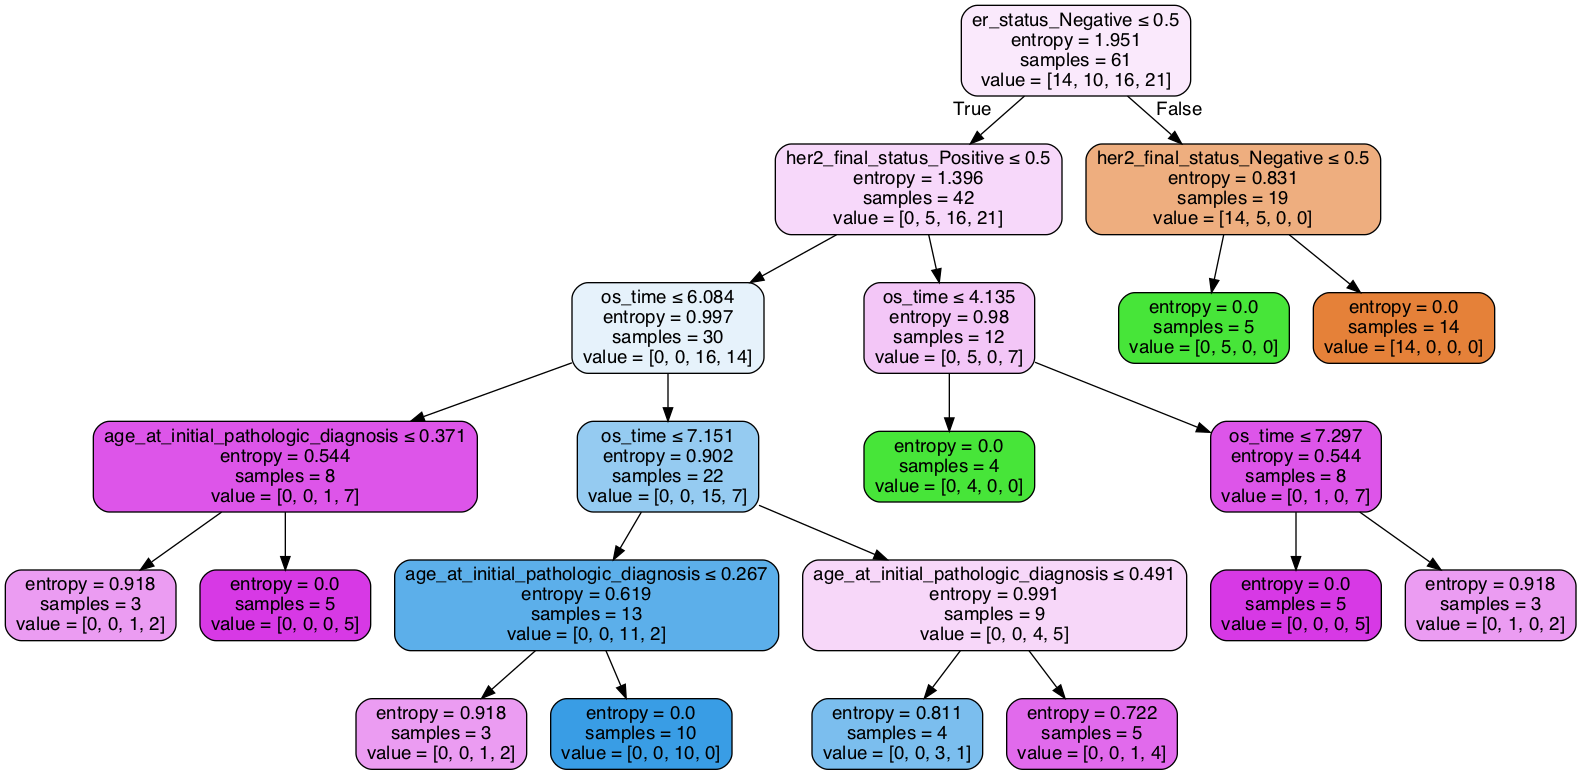

In [149]:
Image(graph.create_png())

### Optimising the Ada Boost  classifier 

In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('always')


clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())


parameters = {'n_estimators': [50,100,150,200,500,1000],
              'learning_rate':[0.001,0.005,0.01,0.05,0.1, 0.5, 1]
             }

scorer = make_scorer(fbeta_score, beta=0.5, average="weighted")
#scorer=make_scorer(f_)
grid_obj = GridSearchCV(clf, parameters,scorer)

grid_fit = grid_obj.fit(X_train,y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


/Users/andra/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/andra/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [156]:
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5, average='weighted')))
print("Balanced Accuracy Score on test data: {:.4f}".format(metrics.balanced_accuracy_score(y_test, best_predictions)))


Final accuracy score on the testing data: 0.7500
Final F-score on the testing data: 0.7806
Balanced Accuracy Score on test data: 0.8095


In [157]:
best_clf.get_params


<bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=None)>

In [191]:

def feature_plot2(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  


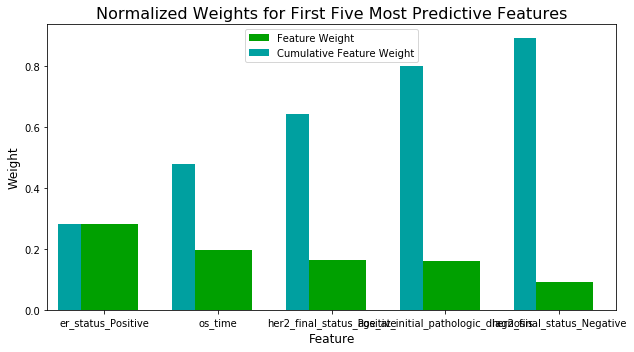

In [192]:
importances = best_clf.feature_importances_
feature_plot2(importances, X_train, y_train)

In [172]:

from sklearn.base import clone


X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

clf = (clone(best_clf)).fit(X_train_reduced, y_train)

reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5, average='weighted')))
print("Balanced Accuracy on testing data: {:.4f}".format(metrics.balanced_accuracy_score(y_test, best_predictions)))

print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5, average='weighted')))
print("Balanced_accuracy on testing data: {:.4f}".format(metrics.balanced_accuracy_score(y_test, reduced_predictions)))

Final Model trained on full data
------
Accuracy on testing data: 0.7500
F-score on testing data: 0.7806
Balanced Accuracy on testing data: 0.8095

Final Model trained on reduced data
------
Accuracy on testing data: 0.6250
F-score on testing data: 0.6588
Balanced_accuracy on testing data: 0.6905


### Conclusion

Overall winner model for classification: `Ada Boost` , with `75% accuracy` on the test set and `F-Beta score of 78%` . The `improvement` in F beta score after optimisation is `14%` . 
The result was significantly better than the selected `dummy classifier` with a score of `32%`.
The reduced model by including only the 5 most important features showed a decrease in accuracy and F-Beta scores to a level lower than in the initial unoptimised model. 

Considering that this is in the medical field, 75% is not a satisfactory accuracy level since a misclassification of a cancer subtype can lead to a wrong treatment course. 

Although we could not significantly increase the accuracy level, I would say that this is mainly due to the small amount of available data for the task (n=77). I think that the obtained performance scores are an indication that we can in fact predict cancer subtype using clinical and expression data, but we need further investigations and analysis on a larger sample size with the goal of obtaining higher classification accuracy scores. 
